<a href="https://colab.research.google.com/github/alexandreib/QuantDesign/blob/main/3_SP500_Portfolio_Alliocation_backtest_with_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Optimization on S&P 500 Stocks Backtest with GBT predictions**


## **Introduction**
In the previous [notebook](https://medium.com/@alexandre.durand/portfolio-optimization-on-s-p-500-stocks-with-backtest-61da87ed91ff), we backtested 4 portfolio optiomization strategies :<br>
1. Random Allocation: Simple approach with no specific optimization for risk or return; often used as a baseline, but generally less efficient in managing return-risk trade-offs.<br>
2. Markowitz (Mean-Variance) Optimization: Balances return and risk by selecting asset weights based on expected returns and correlations, offering a robust strategy but highly dependent on accurate inputs.<br>
3. Minimum Variance: Prioritizes reducing overall portfolio risk without aiming for high returns, making it ideal for risk-averse investors; however, it may underperform in high-return environments.<br>
4. Sharpe Ratio Optimization: Focuses on maximizing risk-adjusted returns, providing a balanced approach between risk and return, but sensitive to the reliability of input data on returns and risk.<br><br>


We used the previous Quater results to generate our optimized weights.
<br><br>
In this notebook, we will run 2 Gradient Boost Tree, to estimate the next Quarter returns for the SP500 Stocks. <br>
Then we will rerun our backtest with the weighted optimized based on the predictions of the GBT.
<br><br>
Imports :


In [1]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import catboost, lightgbm
import sklearn
import sklearn.linear_model
import copy
import datetime as dt
import tqdm

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/drive



## **Prepare Data**



In [3]:
df = pd.read_csv('/content/drive/MyDrive/QuantDesign/Articles/Portfolio Optimization/sp500_20years.csv')

# Calculate daily log returns
df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# # Calculate quarterly log returns Using the first advantage of log Rturns : Tie Additivity
# days before rebalancing :
days = 63
df['Quarterly_Log_Return'] = df.groupby('Ticker')['Log_Return'].rolling(window=days, min_periods=days).sum().reset_index(0, drop=True)

df['target'] = df['Quarterly_Log_Return'].shift(-days)
df.head(2)

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return,target
0,2004-11-22,MMM,37.598114,NaN,NaN,0.043639
1,2004-11-23,MMM,37.365273,-0.006212,NaN,0.054013


## Features Creation

In [4]:
# Calculate Daily Features :
# Calculate RSI (Relative Strength Index)
delta = df.groupby('Ticker')['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD (Moving Average Convergence Divergence)
EMA12 = df.groupby('Ticker', group_keys = False)['Adj Close'].apply(lambda x: x.ewm(span=12).mean())
EMA26 = df.groupby('Ticker', group_keys = False)['Adj Close'].apply(lambda x: x.ewm(span=26).mean())
df.loc[:, 'MACD'] = EMA12 - EMA26
df.loc[:, 'Signal_Line'] = df.groupby('Ticker', group_keys = False)['MACD'].apply(lambda x: x.ewm(span=9, adjust=False).mean())

# Calculate cumsum
df = df.assign(change_sign_cumsum = (np.sign(df.Log_Return) != np.sign(df.Log_Return.shift())).cumsum())
df['change_sign_cumsum'] = df.groupby('change_sign_cumsum')['Log_Return'].cumsum()

# Calculate Daily Informations
for col in ['Log_Return', 'Quarterly_Log_Return'] :
    df.loc[:, f'Date_{col}_std'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].std())
    df.loc[:, f'Date_{col}_mean'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].mean())
    df.loc[:, f'Date_{col}_min'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].min())
    df.loc[:, f'Date_{col}_max'] = df['Date'].map(df.groupby('Date', group_keys = False)[col].max())

for col in ['Log_Return', 'Quarterly_Log_Return'] :
    df.loc[:, f'zscore_{col}'] = (df['Log_Return'] - df[f'Date_{col}_mean']) / df[f'Date_{col}_std']

# Calculate Quaterly Infos
for col in ['Date_Log_Return_mean', 'Log_Return', 'change_sign_cumsum', 'zscore_Log_Return','zscore_Quarterly_Log_Return', 'Quarterly_Log_Return'] :
    df.loc[:, f'Quarter_{col}_Min'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=days, min_periods=days).min())
    df.loc[:, f'Quarter_{col}_Max'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=days, min_periods=days).max())
    df.loc[:, f'Quarter_{col}_Mean'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=days, min_periods=days).mean())
    df.loc[:, f'Quarter_{col}_Std'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=days, min_periods=days).std())
    df.loc[:, f'Quarter_{col}_Sum'] = df.groupby('Ticker', group_keys = False)[col].apply(lambda x: x.rolling(window=days, min_periods=days).sum())

df = df.dropna(subset = ['target'])
df.head(1)

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return,target,RSI,MACD,Signal_Line,change_sign_cumsum,...,Quarter_zscore_Quarterly_Log_Return_Min,Quarter_zscore_Quarterly_Log_Return_Max,Quarter_zscore_Quarterly_Log_Return_Mean,Quarter_zscore_Quarterly_Log_Return_Std,Quarter_zscore_Quarterly_Log_Return_Sum,Quarter_Quarterly_Log_Return_Min,Quarter_Quarterly_Log_Return_Max,Quarter_Quarterly_Log_Return_Mean,Quarter_Quarterly_Log_Return_Std,Quarter_Quarterly_Log_Return_Sum
0,2004-11-22,MMM,37.598114,NaN,NaN,0.043639,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Label Encoders for the tickers

In [5]:
LabelEncoder =  { x : i for i, x in enumerate(df['Ticker'].unique())}
LabelDecoder =  { v : k for k, v in LabelEncoder.items()}
df['Ticker'] = df['Ticker'].map(LabelEncoder)


## Split DataFrame

To backtest our portfolio optimization, we will split on dataframe.
<br><br>
We will use the date columns ot split the data :<br>
- Train dataframe : We will use to train the Machine Learninbg Algorithms (GBT).<br>
- Valid dataframe : We will the valid dataframe, to measure the results of the machine learning algortihtms (GBT), detect overfitt, and to calculate the Covariance Matrice.<br>
- Test dataframe : used for the Backtest.<br>
<br>

For the test dataset we keep 1 rebalancing every 63 days.<br>
We don't do the same for train and valid dataset, on the assumption that more data will help the GBT models, and keep unbiased estiamtes.<br>

In [6]:
dates = list(df['Date'].unique())

dates_train = dates[:int(len(dates) * 0.7)]
dates_valid = dates[int(len(dates) * 0.7) : int(len(dates) * 0.85)]
dates_test = dates[int(len(dates) * 0.85):][0::days] ## Keep 1 rebalancing very 63 days

train = df[df['Date'].isin(dates_train)]
valid = df[df['Date'].isin(dates_valid)]
test = df[df['Date'].isin(dates_test)]
display(test.head(2))

print(f"train : {len(train)} : {train['Date'].min()} -> {train['Date'].max()}")
print(f"valid : {len(valid)} : {valid['Date'].min()} -> {valid['Date'].max()}")
print(f"test : {len(test)} : {test['Date'].min()} -> {test['Date'].max()}")

l_features = [col for col in train.columns if col not in ['Date', 'Adj Close', 'target']]

Y_train = train['target'].values
Y_valid = valid['target'].values
Y_test = test['target'].values

del df

train = train.fillna(train[l_features].mean())
valid = valid.fillna(train[l_features].mean())
test = test.fillna(train[l_features].mean())

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return,target,RSI,MACD,Signal_Line,change_sign_cumsum,...,Quarter_zscore_Quarterly_Log_Return_Min,Quarter_zscore_Quarterly_Log_Return_Max,Quarter_zscore_Quarterly_Log_Return_Mean,Quarter_zscore_Quarterly_Log_Return_Std,Quarter_zscore_Quarterly_Log_Return_Sum,Quarter_Quarterly_Log_Return_Min,Quarter_Quarterly_Log_Return_Max,Quarter_Quarterly_Log_Return_Mean,Quarter_Quarterly_Log_Return_Std,Quarter_Quarterly_Log_Return_Sum
4222,2021-08-31,0,141.965195,-0.007316,-0.035364,-0.127527,31.958487,-0.543483,-0.443756,-0.007316,...,-1.159729,-0.132465,-0.462189,0.236802,-29.117876,-0.041596,0.144130,0.019867,0.043545,1.251650
4285,2021-11-30,0,124.967705,-0.035756,-0.127527,-0.134485,27.820983,-0.947440,-0.281207,-0.035756,...,-0.560819,0.075599,-0.291289,0.151749,-18.351178,-0.136953,-0.039325,-0.084786,0.021027,-5.341549


train : 1539783 : 2004-11-22 -> 2018-09-13
valid : 364500 : 2018-09-14 -> 2021-08-30
test : 5942 : 2021-08-31 -> 2024-06-04


## Lightgbm Train and Predict on Valid data

In [7]:
model_lightgbm = lightgbm.LGBMRegressor(n_estimators = 1_000,
                                verbose = 1,
                                random_state = 42
                                ).fit(train[l_features], Y_train,
                                    categorical_feature = ['Ticker'],
                                    eval_set=[(valid[l_features], Y_valid)],
                                    eval_metric = 'rmse',
                                    callbacks=[lightgbm.callback.early_stopping(20), lightgbm.callback.log_evaluation(10)]
                                    )

valid['pred_lightgbm'] = model_lightgbm.predict(valid[l_features])
valid['error_lightgbm'] = valid['pred_lightgbm'] - Y_valid

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.245065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11948
[LightGBM] [Info] Number of data points in the train set: 1539783, number of used features: 47
[LightGBM] [Info] Start training from score 0.027716
Training until validation scores don't improve for 20 rounds
[10]	valid_0's rmse: 0.187131	valid_0's l2: 0.0350179
[20]	valid_0's rmse: 0.189286	valid_0's l2: 0.035829
Early stopping, best iteration is:
[1]	valid_0's rmse: 0.180915	valid_0's l2: 0.0327302


## Catboost Train and Predict on Valid data

In [8]:
model_catboost = catboost.CatBoostRegressor(iterations = 1_000,
                                   random_seed = 42
                                   ).fit(train[l_features], Y_train,
                                        cat_features = ['Ticker'],
                                        eval_set=(valid[l_features], Y_valid),
                                        early_stopping_rounds = 20,
                                        verbose = 10
                                   )


valid['pred_catboost'] = model_catboost.predict(valid[l_features])
valid['error_catboost'] = valid['pred_catboost'] - Y_valid

Learning rate set to 0.161186
0:	learn: 0.1523480	test: 0.1787113	best: 0.1787113 (0)	total: 1.45s	remaining: 24m 10s
10:	learn: 0.1392399	test: 0.1816097	best: 0.1786105 (1)	total: 11.4s	remaining: 17m 6s
20:	learn: 0.1340588	test: 0.1829651	best: 0.1786105 (1)	total: 21.8s	remaining: 16m 57s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1786104743
bestIteration = 1

Shrink model to first 2 iterations.


## Simple Ensemble witrh weighted mean

In [9]:
model_ensemble = sklearn.linear_model.LinearRegression(positive = True, fit_intercept = False)
l_features_ensemble = ['pred_catboost', 'pred_lightgbm']
model_ensemble.fit(valid[l_features_ensemble], Y_valid)
weights_models = model_ensemble.coef_/model_ensemble.coef_.sum() ## Create <1 coefficients.

valid['pred_ensemble'] = (weights_models * valid[l_features_ensemble]).sum(axis = 1)
valid['error_ensemble'] = valid['pred_ensemble'] - Y_valid

print(weights_models)

[1. 0.]


We will create a reference error, which is based ont the previous Quarter returns. <br>
Similar estimates than what we used in the previous notebook.

In [10]:
valid['pred_reference'] = valid['Quarterly_Log_Return']
valid['error_reference'] = valid['pred_reference'] - Y_valid

Calculate the RMSE (Root Mean Square Error) of the different models :

In [11]:
l_preds = ['pred_reference', 'pred_catboost', 'pred_lightgbm', 'pred_ensemble']
l_erros = ['error_reference', 'error_catboost', 'error_lightgbm', 'error_ensemble']

In [12]:
for errors in l_erros :
    RMSE = np.sqrt(np.sum((valid[errors]**2)))
    print(f'RMSE {errors} : {RMSE:.3f}')

RMSE error_reference : 164.849
RMSE error_catboost : 107.834
RMSE error_lightgbm : 109.225
RMSE error_ensemble : 107.834


We can clearly observe that the RMSE is the minimum for the ensemble betwwen catboost and lgbm.

The Ensemble model brings a very importante deacrease of the Error (will that be enough to generate improvement of the returns once we run the portfolio optimization strategies).

In [13]:
# ax = sns.scatterplot(valid.melt(id_vars = 'target', value_vars = l_preds).rename(columns ={'value' : 'prediction', 'variable' : 'model'}),
#                      x = 'target', y = 'prediction', hue = 'model', sizes = 0.1)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()

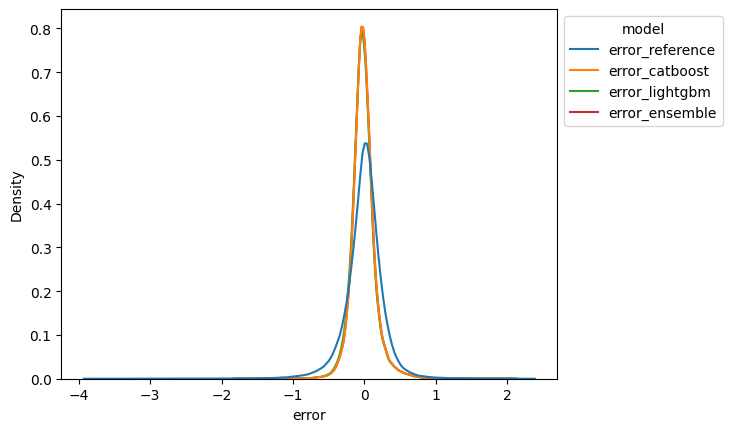

In [14]:
ax = sns.kdeplot(data = valid.melt(id_vars = 'target', value_vars = l_erros).rename(columns ={'value' : 'error', 'variable' : 'model'}),
                 x = 'error', hue = 'model')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

With the graph, we can observer that errors seems to have a mean around 0. <br>
Except the reference model.

Let calculate the acutual values for the mean and variance of the errors :

In [15]:
l_cols_ensemble = [col for col in valid if 'error_' in col]

valid[l_cols_ensemble].describe()

,error_lightgbm,error_catboost,error_ensemble,error_reference
count,364500.000000,364500.000000,364500.000000,364500.000000
mean,-0.016038,-0.010163,-0.010163,-0.004600
std,0.180203,0.178321,0.178321,0.273008
min,-1.767546,-1.790280,-1.790280,-3.864009
25%,-0.111687,-0.104696,-0.104696,-0.128199
50%,-0.026318,-0.021241,-0.021241,0.008358
75%,0.063229,0.067562,0.067562,0.135203
max,2.087122,2.087844,2.087844,2.319131


Errors means are not exactly at 0, but slightly negative. <br>
We can interpret that as negative skewed dataset can pull the model to a slightly negative error mean.
The negative skewed dataset (log returns), could probably be explains by high volatility days, creating negative logs returns outliers.
 <br> <br>
We could in future model try to modify the log return distribution to improve our model prediction and reduce error mean.


## Test Prediction

Use the 2 models, plus the ensemble model to predict our next quarter returns.

In [16]:
test['pred_lightgbm'] = model_lightgbm.predict(test[l_features])
test['pred_catboost'] = model_catboost.predict(test[l_features])
test['pred_ensemble'] = model_ensemble.predict(test[l_features_ensemble])

Decode the Ticker back to Symbols.

In [17]:
test['Ticker'] = test['Ticker'].map(LabelDecoder)
valid['Ticker'] = valid['Ticker'].map(LabelDecoder)

Calculate Covariance Matrice on the valid dataset

In [18]:
def calculate_shrink_cov_matrix (df) :
    masked_arr = np.ma.array(df, mask=np.isnan(df))
    cov_numpy = np.ma.cov(masked_arr, rowvar=False, allow_masked=True, ddof=1).data
    n_samples, n_features = df.shape
    alpha = np.mean(cov_numpy**2)
    mu = np.trace(cov_numpy) / n_features
    mu_squared = mu**2
    num = alpha + mu_squared
    den = (n_samples + 1) * (alpha - mu_squared / n_features)
    shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
    shrunk_cov = (1.0 - shrinkage) * cov_numpy
    shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
    return shrunk_cov

# Creation of the log return Matrix
pivot_returns_valid = valid.pivot_table(values='Quarterly_Log_Return', columns='Ticker', index = 'Date')\
                         .fillna(0)

matrix_covariance = calculate_shrink_cov_matrix(pivot_returns_valid)
matrix_covariance = pd.DataFrame(matrix_covariance, columns = pivot_returns_valid.columns, index = pivot_returns_valid.columns)
matrix_covariance.head(1)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.012336,0.009704,0.007716,-0.000479,0.002997,0.009529,0.007771,0.006855,0.009691,0.008913,...,0.00279,0.014454,0.017831,0.000354,0.012256,0.008299,0.00619,0.010424,0.014303,0.003965


Declaration of the functions to optimize the portfolio (see previous [notebooks](https://medium.com/@alexandre.durand/portfolio-optimisation-on-s-p-500-stocks-46f03732b030) for more explanations).


In [19]:
def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def calculate_portfolio_returns(weights, returns):
    return np.dot(weights, returns)

def variance_objective(weights, cov_matrix):
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return portfolio_variance

### Using Negative Markowitz Objective, as we will use scipy.optimize.minimize
def neg_markowitz_objective(weights, returns, cov_matrix, gamma = 0.2):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return gamma * portfolio_variance - portfolio_returns

### Using Negative Sharpe Ratio, as we will use scipy.optimize.minimize
def neg_sharpe_ratio_objective(weights, returns, cov_matrix, risk_free_rate = 0.03):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return -((portfolio_returns - risk_free_rate)/np.sqrt(portfolio_variance))

### Generic Optimize weights functions
def optimize_weights(log_returns, covariance_matrix, fun=neg_markowitz_objective, x0 = None):
    number_of_tickers = len(log_returns)
    if x0 == None : x0 = np.array([1/number_of_tickers for _ in range(number_of_tickers)])
    if fun == calculate_portfolio_variance : args = (covariance_matrix)
    else : args = (log_returns, covariance_matrix)
    result = sp.optimize.minimize(fun = fun,
                                args = args,
                                x0 = x0,
                                method = 'SLSQP',
                                bounds = tuple((0, 0.3) for _ in range(number_of_tickers)),## we don't want to have more than 30% of the portfolio on 1 asset
                                constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
                                )
    return result.x

## Backtest loop

In [23]:
results = {}
for preds in ['pred_catboost', 'pred_lightgbm', 'pred_ensemble'] : #adding loop for each prediction
    print(preds)
    for date in tqdm.tqdm(test.Date.unique()):
        results[date] = {}
        tickers = test[test.Date == date].Ticker.values
        tickers_returns_future = test[test.Date == date].target # This Quarter returns
        tickers_returns_pred = test[test.Date == date][preds]

        # Create Masks to keep only : Prediction > 0
        mask_preds_positives = tickers_returns_pred.values > 0
        # Create Masks to keep only : Tickers in the covariance Matrice ( calculated on Valid Data)
        mask_tickers_in_covariance_matrice = [True if col in matrix_covariance.columns else False for col in tickers]
        mask = mask_preds_positives & mask_tickers_in_covariance_matrice

        # Filtered Tickers, predictions, and real returns
        tickers = tickers[mask]
        tickers_returns_future = tickers_returns_future[mask]
        tickers_returns_pred = tickers_returns_pred[mask]
        matrix_covariance_filtered = matrix_covariance.loc[tickers, tickers]

        # Creating default weights for 3 types of portfolio potimized
        weights_sharpe = optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = neg_sharpe_ratio_objective)
        results[date][f'returns_sharpe_{preds}'] = (weights_sharpe * tickers_returns_future).sum()

        weights_min_variance= optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = calculate_portfolio_variance)
        results[date][f'returns_min_variance_{preds}'] =  (weights_min_variance * tickers_returns_future).sum()

        weights_mean_min_variance = optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = neg_markowitz_objective)
        results[date][f'returns_mean_min_variance_{preds}'] =  (weights_mean_min_variance * tickers_returns_future).sum()

pred_catboost


100%|██████████| 12/12 [14:06<00:00, 70.51s/it]


pred_lightgbm


100%|██████████| 12/12 [14:05<00:00, 70.43s/it]


pred_ensemble


100%|██████████| 12/12 [14:28<00:00, 72.38s/it]


## Results

In [24]:
results = pd.DataFrame(results).T

<ipython-input-25-4a6bc80dca57>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


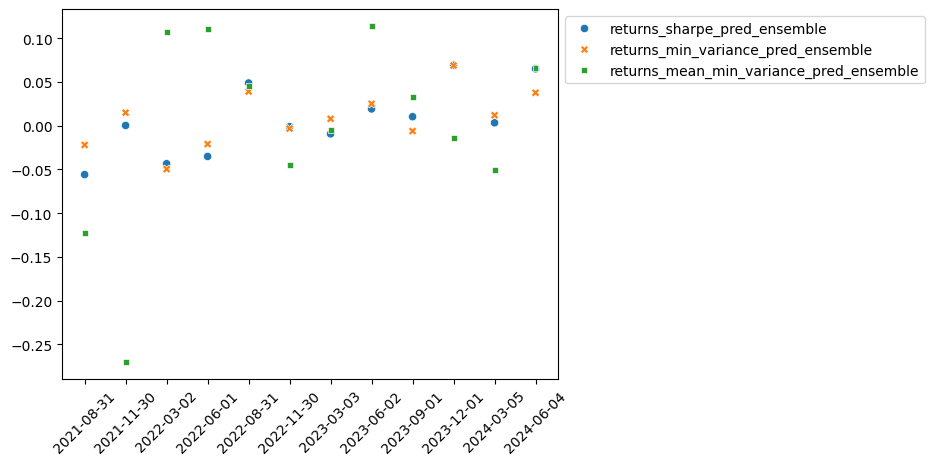

In [25]:
l_returns_columns = [x for x in results.columns if 'returns_' in x[:9]]

fig = plt.figure()
ax = sns.scatterplot(results[l_returns_columns], sizes = 3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

<ipython-input-26-7d718b31462b>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


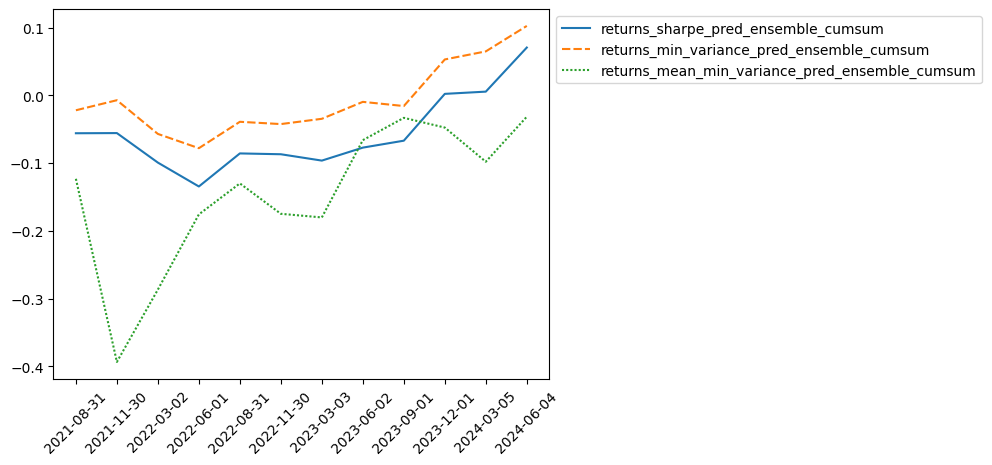

In [26]:
l_returns_columns_cumsum = [x + '_cumsum' for x in l_returns_columns]
results[l_returns_columns_cumsum] = results[l_returns_columns].cumsum()

fig = plt.figure() #figsize = (20, 15))
ax = sns.lineplot(results[l_returns_columns_cumsum], sizes = 3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [27]:
results[l_returns_columns].sum()

,0
returns_sharpe_pred_ensemble,0.070448
returns_min_variance_pred_ensemble,0.102337
returns_mean_min_variance_pred_ensemble,-0.031608
